# Reading Data

In [49]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sktime.forecasting.all import temporal_train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import sktime
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from functools import partial
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb
from sklearn.metrics import make_scorer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [50]:
def model_evaluate(y_test, y_pred,y_train, var):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = MeanAbsolutePercentageError(symmetric=False)
    mape = mape(y_test, y_pred)
    smape = MeanAbsolutePercentageError()
    smape_val = smape(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train = y_train)
    return pd.DataFrame([[mae,mse,rmse,mape,smape_val,mase]],columns = ['MAE','MSE','RMSE','MAPE','sMAPE','MASE'],index= ['Test vs Pred - ' + var])

# Hyperopt Tuning with Regressor

In [51]:
data_eur = pd.read_csv('EUR.csv',index_col=0)
data_eur.index = pd.to_datetime(data_eur.index)
data_eur['EURUSD_Shift']= data_eur['EURUSD'].shift()
data_eur

,EURUSD,YC/FRA5Y - Rate,YC/USA5Y - Rate,Change in Spot,Direction,EURUSD_Shift
Date,,,,,,
2004-08-23,0.81990,0.594002,3.42,0.00850,1,NaN
2004-08-24,0.82650,0.594020,3.46,0.00660,1,0.81990
2004-08-25,0.82710,0.594037,3.46,0.00060,1,0.82650
2004-08-26,0.82750,0.594055,3.46,0.00040,1,0.82710
2004-08-27,0.83160,0.594072,3.42,0.00410,1,0.82750
...,...,...,...,...,...,...
2019-12-25,0.90145,-0.351000,1.72,-0.00075,0,0.90220
2019-12-26,0.90070,-0.354667,1.72,-0.00075,0,0.90145
2019-12-27,0.89490,-0.358333,1.72,-0.00580,0,0.90070


In [52]:
X_eur, y_eur = data_eur[['YC/FRA5Y - Rate', 'YC/USA5Y - Rate','EURUSD_Shift']], data_eur['EURUSD']

In [53]:
X_train, X_test = X_eur.iloc[:int(train_test_size*len(X_eur))], X_eur.iloc[int(train_test_size*len(X_eur)):]
y_train, y_test = y_eur.iloc[:int(train_test_size*len(y_eur))], y_eur.iloc[int(train_test_size*len(y_eur)):]

In [54]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb

from sklearn.metrics import make_scorer

# MAPE computation
def mape(y, yhat, perc=True):
    n = len(yhat.index) if type(yhat) == pd.Series else len(yhat)    
    mape = []
    for a, f in zip(y, yhat):
        # avoid division by 0
        if f > 1e-9:
            mape.append(np.abs((a - f)/a))
    mape = np.mean(np.array(mape))
    return mape * 100. if perc else mape


def train_xgb(params, X_train, y_train):
    """
    Train XGBoost regressor using the parameters given as input. The model
    is validated using standard cross validation technique adapted for time series
    data. This function returns a friendly output for the hyper parameter optimization
    module.
    
    Parameters
    ----------
    params: dict with the parameters of the XGBoost regressor. For complete list see: 
            https://xgboost.readthedocs.io/en/latest/parameter.html
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets    
    
    Returns
    -------
    dict with keys 'model' for the trained model, 'status' containing the hyperopt
    status string and 'loss' with the RMSE obtained from cross-validation
    """
    
    n_estimators = int(params["n_estimators"])
    max_depth= int(params["max_depth"])

    try:
        model = xgb.XGBRegressor(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=params["learning_rate"],
                                 subsample=params["subsample"])

        result = model.fit(X_train, 
                           y_train.values.ravel(),
                           eval_set=[(X_train, y_train.values.ravel())],
                           early_stopping_rounds=50,
                           verbose=False)
        
        # cross validate using the right iterator for time series
        cv_space = TimeSeriesSplit(n_splits=5)
        cv_score = cross_val_score(model, 
                                   X_train, y_train.values.ravel(), 
                                   cv=cv_space, 
                                   scoring=mape_scorer)

        rmse = np.abs(np.mean(np.array(cv_score)))
        return {
            "loss": rmse,
            "status": STATUS_OK,
            "model": model
        }
        
    except ValueError as ex:
        return {
            "error": ex,
            "status": STATUS_FAIL
        }
    
def optimize_xgb(X_train, y_train, max_evals=10):
    """
    Run Bayesan optimization to find the optimal XGBoost algorithm
    hyperparameters.
    
    Parameters
    ----------
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets
    max_evals: the maximum number of iterations in the Bayesian optimization method
    
    Returns
    -------
    best: dict with the best parameters obtained
    trials: a list of hyperopt Trials objects with the history of the optimization
    """
    
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 10),
        "max_depth": hp.quniform("max_depth", 4, 8, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 1),
        "subsample": hp.uniform("subsample", 0.8, 1),
        "gamma": hp.quniform("gamma", 0, 100, 1)
    }

    objective_fn = partial(train_xgb, 
                           X_train=X_train, 
                           y_train=y_train)
    
    trials = Trials()
    best = fmin(fn=objective_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    # evaluate the best model on the test set
    print(f"""
    Best parameters:
        learning_rate: {best["learning_rate"]} 
        n_estimators: {best["n_estimators"]}
        max_depth: {best["max_depth"]}
        sub_sample: {best["subsample"]}
        gamma: {best["gamma"]}
    """)
    return best, trials

In [55]:
mape_scorer = make_scorer(mape, greater_is_better=False)
best, trials = optimize_xgb(X_train, y_train, max_evals=50)

100%|██████████| 50/50 [04:34<00:00,  5.49s/trial, best loss: 2.177601510606001]

    Best parameters:
        learning_rate: 0.018886325869253026 
        n_estimators: 340.0
        max_depth: 5.0
        sub_sample: 0.8918975586951814
        gamma: 70.0
    


In [56]:
best

{'gamma': 70.0,
 'learning_rate': 0.018886325869253026,
 'max_depth': 5.0,
 'n_estimators': 340.0,
 'subsample': 0.8918975586951814}

In [57]:
model = xgb.XGBRegressor(n_estimators=int(best['n_estimators']), 
                                 max_depth=int(best['max_depth']), 
                                 learning_rate=best["learning_rate"],
                                 subsample=best["subsample"])

result = model.fit(X_train, 
                   y_train.values.ravel(),
                   eval_set=[(X_train, y_train.values.ravel())],
                   early_stopping_rounds=50,
                   verbose=False)

In [58]:
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)

<AxesSubplot:xlabel='Date'>

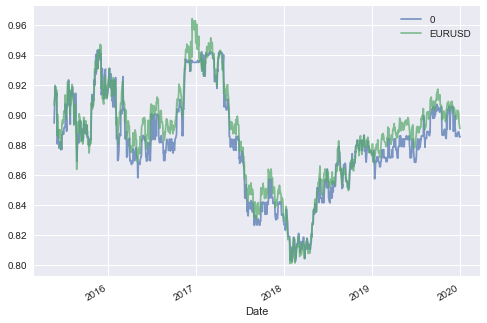

In [59]:
pd.concat(
    [
        pd.Series(ypred_test, index=y_test.index),
        y_test,
    ], axis=1
).plot(alpha=0.7)

In [60]:
MAPE_func = sktime.performance_metrics.forecasting.MeanAbsolutePercentageError(symmetric=False)

In [61]:
print('mse train: {}'.format( round(MAPE_func(y_train, ypred_train),3)))
print('mse test:  {}'.format( round(MAPE_func(y_test, ypred_test),3)))

mse train: 0.004
mse test:  0.009


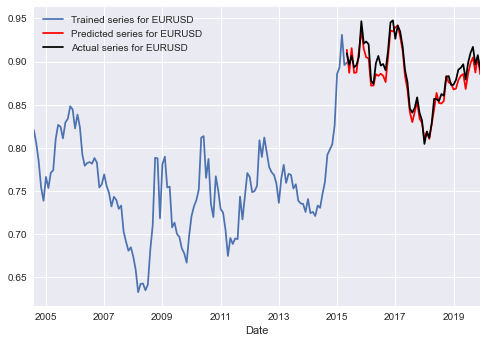

In [64]:
yhat4 = pd.Series(ypred_test, index=y_test.index)
y_train.resample('M').last().plot(label='Trained series for EURUSD')
yhat4.resample('M').last().plot(color='red',label='Predicted series for EURUSD')
y_test.resample('M').last().plot(color = 'black',label='Actual series for EURUSD')
plt.legend()

In [63]:
model_evaluate(y_test,yhat4 ,y_train, 'EURUSD')

,MAE,MSE,RMSE,MAPE,sMAPE,MASE
Test vs Pred - EURUSD,0.007823,0.000088,0.009403,0.008797,0.008845,2.359021
